In [1]:
# import libraries
import math
import numpy as np
from graphviz import Digraph
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Now let's create a data structure to store our variables when we are passing them through a neural network

class Value:

    def __init__(self, data, _children = (), _op='', label = ''):
        self.data = data
        self.label = label
        self.grad = 0 # at initialization is zero
        self._backward = lambda: None # Empty function by default
        self._prev = set(_children)
        self._op = _op

    # Let's us print the class 'nicely' :D
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # addition operation
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    # negation function
    def __neg__(self):
        return self * -1

    # subtraction function
    def __sub__(self, other):
        return self + (-other)

    # reverse addition function
    def __radd__(self, other):
        return self + other
    
    # multiplication function
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    # reverse multiplication function
    def __rmul__(self, other):
        return self * other

    # tanh activation function
    def tanh(self):
        x = self.data
        out = Value((math.exp(2*x) - 1)/(math.exp(2*x) + 1), (self, ), 'tanh')

        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward
        
        return out

    # exponentiation function
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    # power function
    def __pow__(self, k):
        assert isinstance(k, (int, float))
        out = Value(self.data ** k, (self, ), f'pow({k})')

        def _backward():
            self.grad += k * (self.data ** (k-1)) * out.grad
        out._backward = _backward

        return out

    # division function
    def __truediv__(self, k):
        return self * (k**-1)

    # backward pass
    def backward(self):
        # Topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad += 1.0 # Gradient initialization
        for node in reversed(topo):
            node._backward()

In [3]:
# To visiualize our connection map

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [4]:
# Example 2

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

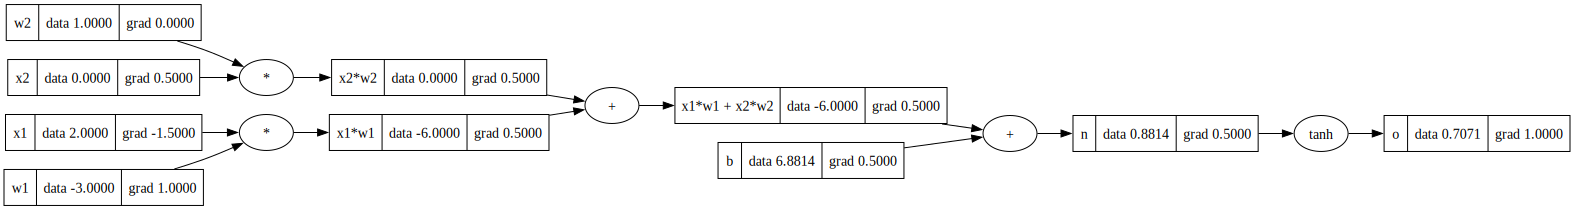

In [5]:
draw_dot(o)

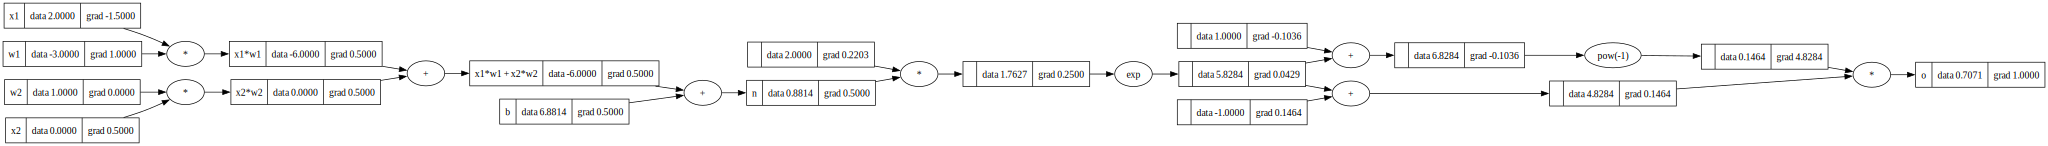

In [6]:
# Example 2 (tanh re-implementation)

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# tanh re-implementation with basic operators
e = (2*n).exp()
o = (e - 1) / (e + 1); o.label = 'o'
o.backward()
draw_dot(o)

In [7]:
# Equivalent pytorch implementation

import torch

x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print(f'Gradient of x1: {x1.grad.item()}')
print(f'Gradient of x2: {x2.grad.item()}')
print(f'Gradient of w1: {w1.grad.item()}')
print(f'Gradient of w2: {w2.grad.item()}')

0.7071066904050358
---
Gradient of x1: -1.5000003851533106
Gradient of x2: 0.5000001283844369
Gradient of w1: 1.0000002567688737
Gradient of w2: 0.0


In [8]:
# Neural network class

class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # we want to perform: w*x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    # it's just a list of neurons

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [72]:
# Mini-dataset
xs = [[2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [76]:
# Network initialization
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])

In [77]:
# The whole process - Gradient descent (optimizing the loss)

step_size = 0.1 # learning rate

for k in range(20):

    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # Backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # Parameters update 
    for p in n.parameters():
        p.data += -step_size * p.grad
    
    # Print the loss
    print(f'Loss in epoch {k+1}: {loss.data:.4f}')

Loss in epoch 1: 3.8936
Loss in epoch 2: 3.6604
Loss in epoch 3: 3.3299
Loss in epoch 4: 3.0298
Loss in epoch 5: 2.5486
Loss in epoch 6: 2.2083
Loss in epoch 7: 1.9250
Loss in epoch 8: 2.0664
Loss in epoch 9: 0.3616
Loss in epoch 10: 0.1199
Loss in epoch 11: 0.0997
Loss in epoch 12: 0.0856
Loss in epoch 13: 0.0750
Loss in epoch 14: 0.0667
Loss in epoch 15: 0.0600
Loss in epoch 16: 0.0544
Loss in epoch 17: 0.0497
Loss in epoch 18: 0.0458
Loss in epoch 19: 0.0424
Loss in epoch 20: 0.0394


In [78]:
# Final predictions :)
ypred

[Value(data=0.9135407076423383),
 Value(data=-0.935955273155963),
 Value(data=-0.8751775356303003),
 Value(data=0.8893506336653993)]